# Training and visualising neural networks for MNIST

#### Alexei Stepanenko

## TOC:
* [Section 1 (MNIST dataset)](#section_1) We load the MNIST dataset into PyTorch.
* [Section 2 (Fully connected neural network)](#section_2) We train a classifier using a fully connected neural network and visualise the activation of the hidden neurons for a given input.
* [Section 3 (Convolutions - edge detection and blur)](#section_3) We explore manually defined convolutions and a CNNs for edge detection and blur.
* [Section 4 (Convolutional neural network)](#section_4) We train a classifier using a CNN and nd visualise the activation of the hidden convolutions and neurons for a given input.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,  Lambda
from torchvision.io import read_image
from torch import nn
import torch.nn.functional as F

## MNIST dataset <a id=’section_1’></a>

#### Importing data

First, we want to import and plot the dataset. 

Downloading and importing training data:

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 88340358.46it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31140281.19it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26790101.13it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10084980.82it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Downloading and importing testing data:

In [3]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

Datapoints have the following format:

In [6]:
x, y = training_data[0]
print('Input shape: ', x.shape)
print('Output type:', type(y))

Input shape:  torch.Size([1, 28, 28])
Output type: <class 'int'>


Plotting random sample of 3 datapoints:

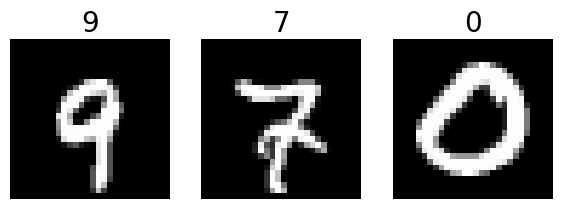

In [7]:
rand_int = np.random.randint(0,len(training_data) - 1,size = (3,))
fig, ax = plt.subplots(1,3, figsize = (7,3))
ax[0].imshow(training_data[rand_int[0]][0].squeeze(),cmap= "gray")
ax[0].axis("off")
ax[0].title.set_text(training_data[rand_int[0]][1])
ax[0].title.set_size(20)
ax[1].imshow(training_data[rand_int[1]][0].squeeze(),cmap= "gray")
ax[1].axis("off")
ax[1].title.set_text(training_data[rand_int[1]][1])
ax[1].title.set_size(20)
ax[2].imshow(training_data[rand_int[2]][0].squeeze(),cmap= "gray")
ax[2].axis("off")
ax[2].title.set_text(training_data[rand_int[2]][1])
ax[2].title.set_size(20)
plt.show()

## Fully connected neural network <a id=’section_2’></a>

First we define a fully connected neural network with ReLU activation functions, arbitrary depth/width and linear output. 

In [8]:
class NN_ReLU_flatten(nn.Module):
    '''
    Deep neural network with `d` input features `d_out` output features with `len(neuron_lst)` hidden layers 
    whose respective widths are given by list of positive integers `neuron_lst`.
    
    Input is flattened with `nn.Flatten(start_dim = 1)` such as to transform the input image dataset
    `[x_1,...,x_m]`, with each image `x_j` represented as a (1,n,n) tensor, to a dataset `[z_1,...,z_m]`, 
    where each `z_j` is a (n*n,) tensor.
    '''
    def __init__(self,d, d_out, neuron_lst):
        super(NN_ReLU_flatten,self).__init__()
        self.flatten = nn.Flatten(start_dim = 1) # Don't flatten along first axis
        lst = neuron_lst[:]
        tmp = nn.Sequential()
        lst.insert(0,d)
        lst.append(d_out)
        for i in range(len(lst) - 2):
            tmp.add_module(f'Linear_{i}', nn.Linear(lst[i],lst[i+1]))
            tmp.add_module(f'Activation_{i}', nn.ReLU())
        tmp.add_module(f'Linear_output', nn.Linear(lst[len(lst)-2],lst[len(lst)-1]))
        self.stack = tmp
        
    def forward(self,x):
        x = self.flatten(x)
        return self.stack(x)

In [9]:
# Parameters
neuron_lst = [15*15,10*10,5*5]

In [10]:
model = NN_ReLU_flatten(28*28,10,neuron_lst)

In [11]:
# Testing model
X_batch = next(iter(DataLoader(training_data,batch_size = 2)))[0]
model(X_batch)

tensor([[-0.1350, -0.0605, -0.0325, -0.1727, -0.1689,  0.1222,  0.1095,  0.0778,
          0.1102,  0.0145],
        [-0.1436, -0.0551, -0.0252, -0.1796, -0.1755,  0.1276,  0.1082,  0.0796,
          0.1167,  0.0159]], grad_fn=<AddmmBackward0>)

In [12]:
# Testing loss function
loss_fn = nn.CrossEntropyLoss()
X,y = next(iter(DataLoader(training_data,batch_size = 2)))
y_hat = model(X)
print('Loss for single datapoint: ', loss_fn(y_hat[0],y[0]))
print('Cost with two datapoints: ', loss_fn(y_hat,y))

Loss for single datapoint:  tensor(2.1730, grad_fn=<NllLossBackward0>)
Cost with two datapoints:  tensor(2.3063, grad_fn=<NllLossBackward0>)


In [13]:
print('Test (expected output approx. 0): ', (loss_fn(y_hat[0],y[0]) + loss_fn(y_hat[1],y[1]))/ 2 - loss_fn(y_hat,y))

Test (expected output approx. 0):  tensor(0., grad_fn=<SubBackward0>)


In [14]:
def give_cost(loader, model, loss_fn):
    num_batch = 0
    cost = 0
    for X, y in loader:
        cost += loss_fn(model(X),y)
        num_batch += 1
    cost = cost / num_batch
    return cost


class MNISTex_FNN:

    def __init__(self,dataset,testset):
        self.dataset = dataset
        self.testset = testset
    
    ### Parameters
    neuron_lst = [5,5]
    weight_decay = 0
    # Learning parameters
    learning_rate = 0.1
    n_epochs = 50
    batch_size = 20 
    opt_type = 'sgd'
    learning_rate = 0.1
    momentum = 0
    # Rate of printing
    n_print = 25 # Print after every `n_print` epochs
    
    
    # Model attribute
    model = None
    
    # History lists (recording every epoch)
    Jtr_hist = None # Training cost history 
    Jtst_hist = None # Testing cost history 
        
    def go(self):
        dataset = self.dataset
        testset = self.testset
        learning_rate = self.learning_rate
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        n_print = self.n_print
        weight_decay = self.weight_decay
        neuron_lst = self.neuron_lst
        model = self.model
        momentum = self.momentum

        # Initialising history lists
        Jtr_hist = []
        Jtst_hist = []
        
        # Specify training and testing dataloaders. (By convention testing data has batch size = 1).
        data_train = DataLoader(dataset, batch_size = batch_size)
        data_tst = DataLoader(testset, batch_size = len(testset))

        # Initiating optimiser
        model = NN_ReLU_flatten(28*28,10,self.neuron_lst) # MNIST images are 28x28, with 10 labels.
        loss_fn = nn.CrossEntropyLoss()
        if self.opt_type == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
        elif self.opt_type == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        
        tr_err = None
        tst_err = None
        

        for t in range(n_epochs):
            Jtr_epoch = 0.0 # Training cost for epoch
            for batch, (X,y) in enumerate(data_train):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Recording loss
                Jtr_epoch += loss.item()
            Jtr_epoch = Jtr_epoch/len(data_train)
            Jtr_hist.append(Jtr_epoch)
            tst_err = give_cost(data_tst, model, loss_fn).item()
            Jtst_hist.append(tst_err)

            # Printing every `n_print` epochs
            if t % n_print == 0:
                print(f"Epoch {t}. Training cost: {Jtr_epoch:>6f}.")
        
        
        tr_err = give_cost(data_train, model, loss_fn).item(); tst_err = give_cost(data_tst, model, loss_fn).item()
        print(f"End. Training error: {tr_err:>6f}. Testing error: {tst_err:>6f}.")

        self.model = model
        self.Jtst_hist = Jtst_hist; self.Jtr_hist = Jtr_hist 
        self.tr_err = tr_err; self.tst_err = tst_err
        
    
    def plot_err(self):
        '''
        Plots training and testing error for evaluation
        '''
        plt.plot(np.linspace(1, len(self.Jtr_hist),len(self.Jtr_hist)), self.Jtr_hist, label = 'Batch training error')
        plt.plot(np.linspace(1, len(self.Jtst_hist),len(self.Jtst_hist)),self.Jtst_hist, label = 'Testing error')
        plt.plot([1,len(self.Jtr_hist)], [self.tr_err,self.tr_err], label = 'End training error', linestyle = '--')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        
        
    def plot_pred(self, n):
        fig, ax = plt.subplots(n,n,figsize = (7,7))
        for i in range(n):
            for j in range(n):
                ind = np.random.randint(len(self.testset))
                x = self.testset[ind][0]
                y = self.testset[ind][1]
                ax[i,j].imshow(x.squeeze(),cmap= "gray")
                pred = torch.argmax(self.model(x))
                if pred == y:
                    ax[i,j].set_title(f'{pred}', color = 'green', size = 12)
                else:
                    ax[i,j].set_title(f'{pred}', color = 'red', size = 12)
                ax[i,j].axis('off')
        plt.tight_layout()
        plt.show()
        
        

In [15]:
ex = MNISTex_FNN(training_data, test_data)
ex.neuron_lst = [14*14,7*7]
ex.weight_decay = 0.003
# Learning parameters
ex.learning_rate = 0.1
ex.n_epochs = 10
ex.batch_size = 30 
ex.opt_type = 'sgd'
ex.momentum = 0 
# Rate of printing
ex.n_print = 1 # Print after every `n_print` epochs
ex.go()

Epoch 0. Training cost: 0.374937.
Epoch 1. Training cost: 0.162205.
Epoch 2. Training cost: 0.133290.
Epoch 3. Training cost: 0.121491.
Epoch 4. Training cost: 0.115245.
Epoch 5. Training cost: 0.111274.
Epoch 6. Training cost: 0.108713.
Epoch 7. Training cost: 0.106761.
Epoch 8. Training cost: 0.105300.
Epoch 9. Training cost: 0.104313.
End. Training error: 0.118005. Testing error: 0.127286.


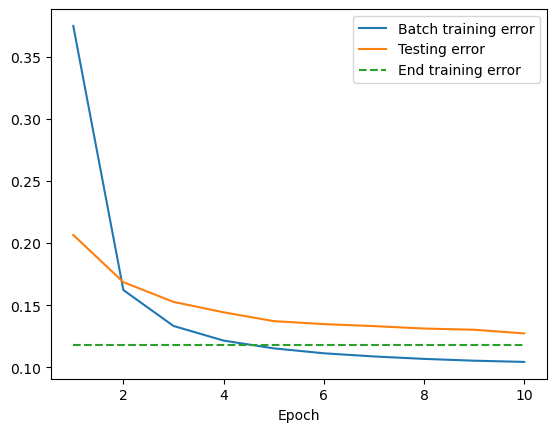

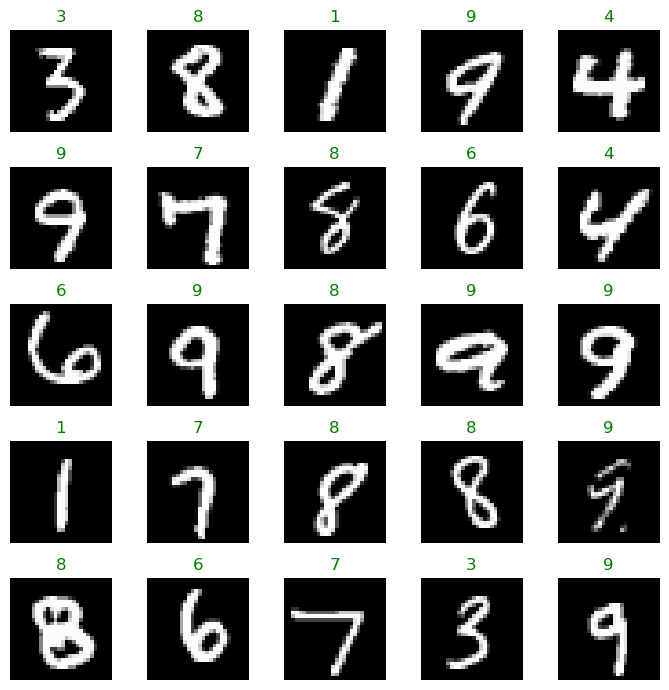

In [16]:
ex.plot_err()
ex.plot_pred(5)

Next, we shall plot the outputs of the individual layers in order to visualise the action of the neural network. Precisely, we shall plot the neuron output (both pre- and post-activation) against the neuron number. 

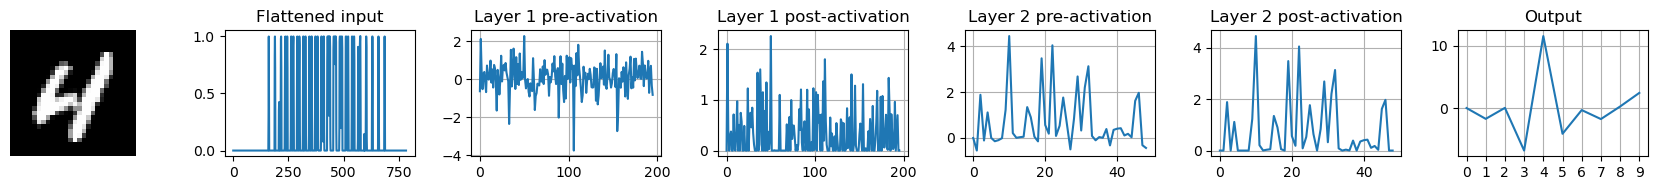

In [17]:
# Defining "forward hook" (see https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5)

activation = {} # Dictionary where outputs of different layers are stored
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Registering forward hooks to be placed into the dictionary `activation`
ind = np.random.randint(0,len(test_data) - 1)
ex.model.stack.Linear_0.register_forward_hook(get_activation('Linear_0'))
ex.model.stack.Activation_0.register_forward_hook(get_activation('Activation_0'))
ex.model.stack.Linear_1.register_forward_hook(get_activation('Linear_1'))
ex.model.stack.Activation_1.register_forward_hook(get_activation('Activation_1'))
x = test_data[ind][0]
output = ex.model(x)

# Plotting
fig, ax = plt.subplots(1,7,figsize = (17,2))
ax[0].imshow(x[0],cmap = 'gray')
ax[0].axis('off')
ax[0].grid()
ax[1].plot(x[0].flatten())
ax[1].set_title('Flattened input')
ax[2].plot(activation['Linear_0'][0])
ax[2].grid()
ax[2].set_title('Layer 1 pre-activation')
ax[3].plot(activation['Activation_0'][0])
ax[3].set_title('Layer 1 post-activation')
ax[3].grid()
ax[4].plot(activation['Linear_1'][0])
ax[4].set_title('Layer 2 pre-activation')
ax[4].grid()
ax[5].plot(activation['Activation_1'][0])
ax[5].set_title('Layer 2 post-activation')
ax[5].grid()
ax[6].plot(output.detach()[0])
ax[6].set_title('Output')
ax[6].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[6].grid()
plt.tight_layout()
plt.show()

The outputs of the individual layers are very noisy when plotted in the way. This is perhaps not suprising, since the neurons may be arbitrarily reordered without changing the output of the neural network. One idea to identify a canonical ordering of the neurons would be to consider a permutation
$$
\pi^*\in \mathrm{argmin}_{\pi} \mathbb{E}_{x \sim \hat X} \|\nabla \pi z^{(j)}(x)\|^2_{\ell^2}
$$
where here $\nabla$ denotes the discrete (finite-difference) derivative operator  acting on vectors, the min is taken over permuations $\pi$ (which may be realised as matrices) and $\hat X$ denotes the the empirical distributation for a subset of the dataset. Integral representations for neural networks: https://arxiv.org/abs/2109.09710.

## Convolutions - edge detection and blur <a id=’section_3’></a>

As a preliminary to constructing and training a convolutional neural network, we shall define a 2D-convolutional layer with one input channel and three output channels giving horizonal edge detection, vertical edge detection and gaussian blur. Furthermore, we shall define a simple CNN for global edge detection. 

#### Initiating a convolutional layer

Defining CNN layer with one input channel, one output channel, a kernel sixe of (3,3) and a padding size of one. 

In [18]:
conv = torch.nn.Conv2d(1,3,3,padding = 0);
conv

Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))

Parameters of the CNN layer:

In [19]:
for par in conv.named_parameters(): 
    print(par)

('weight', Parameter containing:
tensor([[[[-0.0774,  0.1081, -0.2179],
          [-0.0207, -0.1670, -0.1762],
          [ 0.0717, -0.1178, -0.1556]]],


        [[[-0.3233,  0.0469,  0.0844],
          [ 0.3254,  0.1025,  0.2976],
          [-0.1033,  0.3085,  0.0299]]],


        [[[ 0.2333,  0.2285,  0.3128],
          [ 0.0408,  0.1822, -0.2239],
          [ 0.0992, -0.2951, -0.1191]]]], requires_grad=True))
('bias', Parameter containing:
tensor([-0.2894, -0.2363,  0.0099], requires_grad=True))


In [20]:
conv.weight[0,0]

tensor([[-0.0774,  0.1081, -0.2179],
        [-0.0207, -0.1670, -0.1762],
        [ 0.0717, -0.1178, -0.1556]], grad_fn=<SelectBackward0>)

Applying the random CNN layer to an MNIST datapoint. 

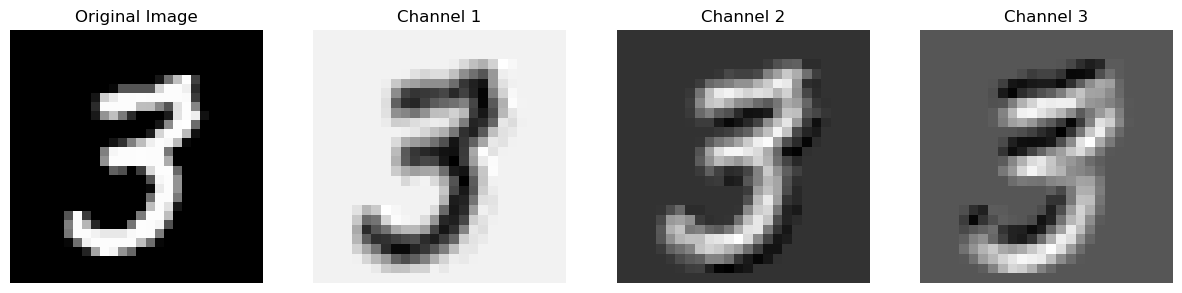

In [21]:
# Picking random MNIST datapoint and applying convolution
rand_int = np.random.randint(0,len(training_data) - 1,size = (1,))
image = training_data[rand_int[0]][0]
conv_image = conv(image)
conv_image = conv_image.detach().numpy()
# Plotting
fig, ax = plt.subplots(1,4, figsize = (15,7))
ax[0].imshow(image.squeeze(),cmap= "gray")
ax[0].axis("off")
ax[0].set_title('Original Image')
ax[1].imshow(conv_image[0],cmap= "gray")
ax[1].axis("off")
ax[1].set_title('Channel 1')
ax[2].imshow(conv_image[1],cmap= "gray")
ax[2].axis("off")
ax[2].set_title('Channel 2')
ax[3].imshow(conv_image[2],cmap= "gray")
ax[3].axis("off")
ax[3].set_title('Channel 3')
plt.show()

#### Edge detection and blur convolutions

Defining edge and blur kernels and setting channels of above convolutional layer. 

In [22]:
# Sobol edge detection
hor_edge = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]],dtype = torch.float32)
ver_edge = hor_edge.T
# Gaussian blur
blur = torch.tensor([[1,2,1],[2,4,2],[1,2,1]],dtype = torch.float32)/16
# Setting parameters of convolutional layer
conv.weight = nn.Parameter(torch.stack((hor_edge,ver_edge,blur)).reshape(3,1,3,3))
conv.bias = nn.Parameter(torch.tensor([0,0,0], dtype = torch.float32))

In [23]:
# Picking random MNIST datapoint and applying convolution
rand_int = np.random.randint(0,len(training_data) - 1,size = (1,))
image = training_data[rand_int[0]][0].reshape(1,1,28,28)
conv_image = conv(image).detach().numpy()

Plotting the Sobol edge detection convolutions and the Gaussian blur (white = positive, red = negative).

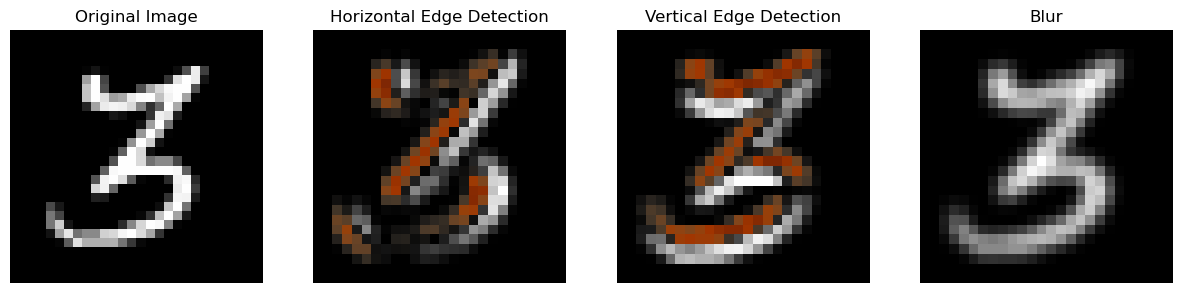

In [24]:
# Picking random MNIST datapoint and applying convolution
rand_int = np.random.randint(0,len(training_data) - 1,size = (1,))
image = training_data[rand_int[0]][0].reshape(1,1,28,28)
conv_image = conv(image).detach().numpy()
# Positive and negative parts of convolution
pos_conv = nn.ReLU()(conv(image)).detach().numpy()[0]
neg_conv = nn.ReLU()(-conv(image)).detach().numpy()[0]
# Plotting
fig, ax = plt.subplots(1,4, figsize = (15,7))
ax[0].imshow(image.squeeze(),cmap= "gray")
ax[0].axis("off")
ax[0].set_title('Original Image')
ax[1].imshow(pos_conv[0],cmap= "gray",)
ax[1].imshow(neg_conv[0],cmap= "Oranges",alpha = neg_conv[0]/np.max(neg_conv[0]))
ax[1].axis("off")
ax[1].set_title('Horizontal Edge Detection')
ax[2].imshow(pos_conv[1],cmap= "gray",)
ax[2].imshow(neg_conv[1],cmap= "Oranges",alpha = neg_conv[1]/np.max(neg_conv[1]))
ax[2].axis("off")
ax[2].set_title('Vertical Edge Detection')
ax[3].imshow(pos_conv[2],cmap= "gray",)
ax[3].axis("off")
ax[3].set_title('Blur')
plt.show()

#### Pooling

In [25]:
pool2 = nn.MaxPool2d(2,2)
pool4 = nn.MaxPool2d(4,4)
# Picking random MNIST datapoint and applying convolution
rand_int = np.random.randint(0,len(training_data) - 1,size = (1,))
image = training_data[rand_int[0]][0].reshape(1,1,28,28)
pool2_im = pool2(image).detach().numpy()[0,0]
pool4_im = pool4(image).detach().numpy()[0,0]

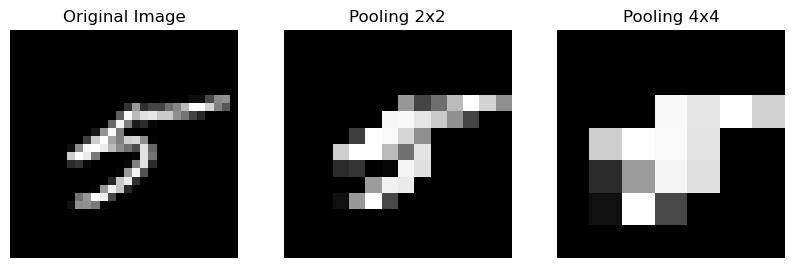

In [26]:
# Plotting
fig, ax = plt.subplots(1,3, figsize = (10,5))
ax[0].imshow(image.squeeze(),cmap= "gray")
ax[0].axis("off")
ax[0].set_title('Original Image')
ax[1].imshow(pool2_im,cmap= "gray",)
ax[1].axis("off")
ax[1].set_title('Pooling 2x2')
ax[2].imshow(pool4_im,cmap= "gray",)
ax[2].axis("off")
ax[2].set_title('Pooling 4x4')

plt.show()

#### Global edge detection neural network

Here, we set the parameters of a simple one CNN for edge detection.

- Input: one channel image
- Convolutional Layer: 4 channels - Up/Down/Left/Right edge detection (Prewitt or Sobol)
- Activation function: ReLU
- Output: sum of 4 channels in hidden layer


In [27]:
def edge_sobol(im):
    conv = torch.nn.Conv2d(1,4,3,padding = 0);
    right = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]],dtype = torch.float32)
    left = - right
    down = right.T
    up = - down
    conv.weight = nn.Parameter(torch.stack((right,left,up,down)).reshape(4,1,3,3))
    conv.bias = nn.Parameter(torch.tensor([0,0,0,0], dtype = torch.float32))
    z = conv(im)
    a = nn.ReLU()(z)
    out = a[0,0] + a[0,1] + a[0,2] + a[0,3]
    return out 

def edge_prewitt(im):
    conv = torch.nn.Conv2d(1,4,3,padding = 0);
    right = torch.tensor([[1,0,-1],[1,0,-1],[1,0,-1]],dtype = torch.float32)
    left = - right
    down = right.T
    up = - down
    conv.weight = nn.Parameter(torch.stack((right,left,up,down)).reshape(4,1,3,3))
    conv.bias = nn.Parameter(torch.tensor([0,0,0,0], dtype = torch.float32))
    z = conv(im)
    a = nn.ReLU()(z)
    out = a[0,0] + a[0,1] + a[0,2] + a[0,3]
    return out 

Text(0.5, 1.0, 'Prewitt edge detection')

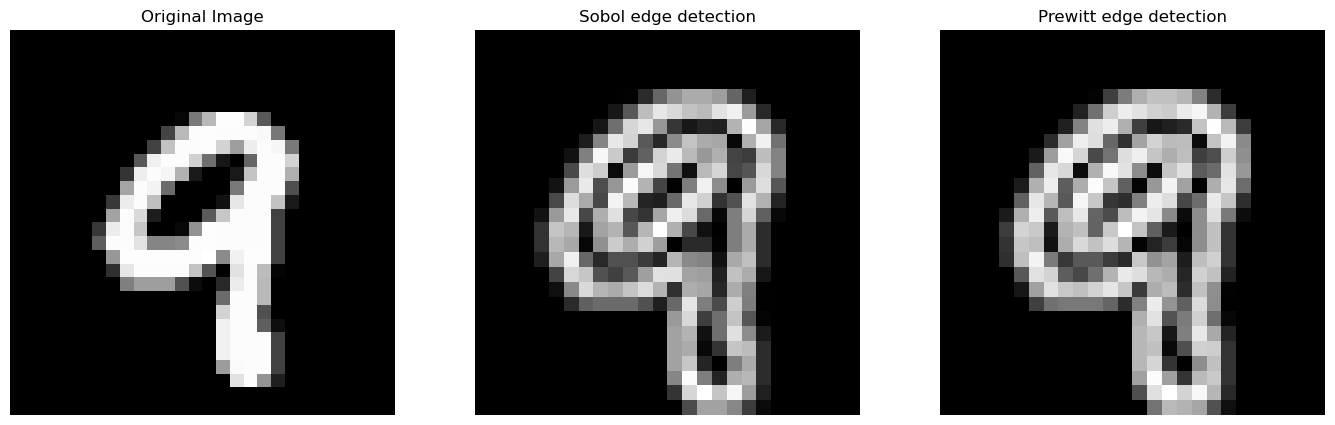

In [28]:
rand_int = np.random.randint(0,len(training_data) - 1,size = (1,))
im = training_data[rand_int[0]][0].reshape(1,1,28,28)
im_sob = edge_sobol(im)
im_pre = edge_prewitt(im)
fig, ax = plt.subplots(1,3,figsize = (17,5))
ax[0].imshow(im.detach().numpy()[0,0],cmap = "gray")
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(im_sob.detach().numpy(),cmap = "gray")
ax[1].axis('off')
ax[1].set_title('Sobol edge detection')
ax[2].imshow(im_pre.detach().numpy(),cmap = "gray")
ax[2].axis('off')
ax[2].set_title('Prewitt edge detection')

## Convolutional neural networks <a id=’section_4’></a>

Finally, we shall train and visualise a simple CNN for MNIST. 

In [29]:
class CNN_MNIST(nn.Module):
    '''
    Parameters: 
    - `channel_lst` (length 2 list of pos. ints) 
    - `neuron_lst` (list of pos. ints)
    - `pixel` (pos. int)
    - `d_out` (pos. int)

    Architecture:
    - Input: Image with one channel (pixel size `pixel` divisible by 4)
    - Size 5 convolution (`channel_lst[0]` channels) -> ReLU -> Pooling -> Size 5 convolution (`channel_lst[1]` channels) -> ReLU -> Pooling
    - FNN with `d_out` output features and `len(neuron_lst)` hidden layers whose respective widths are given by the list of positive integers `neuron_lst`.
    - Output: Size `d_out` vector
    
    Note: Padding of size 2 is used for both convolutional layers
    '''
    def __init__(self,pixels, d_out, neuron_lst, channel_lst):
        super(CNN_MNIST,self).__init__()
        tmp = nn.Sequential()
        # Convolution and pooling
        tmp.add_module(f'Conv_1', nn.Conv2d(1, channel_lst[0], 5, padding = 2))
        tmp.add_module(f'Act_1', nn.ReLU())
        tmp.add_module(f'Pool_1',nn.MaxPool2d(2, 2))
        tmp.add_module(f'Conv_2', nn.Conv2d(channel_lst[0], channel_lst[1], 5, padding = 2))
        tmp.add_module(f'Act_2', nn.ReLU())
        tmp.add_module(f'Pool_2',nn.MaxPool2d(2, 2))
        # Flatten 
        tmp.add_module(f'Flatten',nn.Flatten(start_dim = 1)) # Don't flatten along first axis
        # FNN
        lst = neuron_lst[:]
        lst.insert(0,channel_lst[-1]*(int(pixels/4))**2) # Flattened size of second convolutional layer after pooling 
        lst.append(d_out)
        for i in range(len(lst) - 2):
            tmp.add_module(f'FNN_lin_{i}', nn.Linear(lst[i],lst[i+1])) 
            tmp.add_module(f'FNN_act_{i}', nn.ReLU())
        tmp.add_module(f'Linear_output', nn.Linear(lst[len(lst)-2],lst[len(lst)-1]))
        self.stack = tmp
        
    def forward(self,x):
        return self.stack(x)

In [30]:
class MNISTex_CNN:
    
    def __init__(self,dataset,testset):
        self.dataset = dataset
        self.testset = testset
    
    ### Parameters
    channel_lst = [20,10]
    neuron_lst = [30,10]
    weight_decay = 0
    # Learning parameters
    learning_rate = 0.1
    n_epochs = 50
    batch_size = 20 
    opt_type = 'sgd'
    learning_rate = 0.1
    momentum = 0
    # Rate of printing
    n_print = 25 # Print after every `n_print` epochs
    
    
    # Model attribute
    model = None
    
    # History lists (recording every epoch)
    Jtr_hist = None # Training cost history 
    Jtst_hist = None # Testing cost history 
        
    def go(self):
        dataset = self.dataset
        testset = self.testset
        learning_rate = self.learning_rate
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        n_print = self.n_print
        weight_decay = self.weight_decay
        neuron_lst = self.neuron_lst
        channel_lst = self.channel_lst
        model = self.model
        momentum = self.momentum

        # Initialising history lists
        Jtr_hist = []
        Jtst_hist = []
        
        # Specify training and testing dataloaders. (By convention testing data has batch size = 1).
        data_train = DataLoader(dataset, batch_size = batch_size)
        data_tst = DataLoader(testset, batch_size = len(testset))

        # Initiating optimiser
        model = CNN_MNIST(28, 10, self.neuron_lst, self.channel_lst) # MNIST images are 28x28, with 10 labels.
        loss_fn = nn.CrossEntropyLoss()
        if self.opt_type == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
        elif self.opt_type == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        
        tr_err = None
        tst_err = None
        

        for t in range(n_epochs):
            Jtr_epoch = 0.0 # Training cost for epoch
            for batch, (X,y) in enumerate(data_train):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Recording loss
                Jtr_epoch += loss.item()
            Jtr_epoch = Jtr_epoch/len(data_train)
            Jtr_hist.append(Jtr_epoch)
            tst_err = give_cost(data_tst, model, loss_fn).item()
            Jtst_hist.append(tst_err)

            # Printing every `n_print` epochs
            if t % n_print == 0:
                print(f"Epoch {t}. Training cost: {Jtr_epoch:>6f}.")
        
        
        tr_err = give_cost(data_train, model, loss_fn).item(); tst_err = give_cost(data_tst, model, loss_fn).item()
        print(f"End. Training error: {tr_err:>6f}. Testing error: {tst_err:>6f}.")

        self.model = model
        self.Jtst_hist = Jtst_hist; self.Jtr_hist = Jtr_hist 
        self.tr_err = tr_err; self.tst_err = tst_err
        
    
    def plot_err(self):
        '''
        Plots training and testing error for evaluation
        '''
        plt.plot(np.linspace(1, len(self.Jtr_hist),len(self.Jtr_hist)), self.Jtr_hist, label = 'Batch training error')
        plt.plot(np.linspace(1, len(self.Jtst_hist),len(self.Jtst_hist)),self.Jtst_hist, label = 'Testing error')
        plt.plot([1,len(self.Jtr_hist)], [self.tr_err,self.tr_err], label = 'End training error', linestyle = '--')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        
        
    def plot_pred(self, n):
        '''
        Plot a n by n grid of random datapoints and their predictions
        '''
        fig, ax = plt.subplots(n,n,figsize = (7,7))
        for i in range(n):
            for j in range(n):
                ind = np.random.randint(len(self.testset))
                x = self.testset[ind][0]
                y = self.testset[ind][1]
                ax[i,j].imshow(x.squeeze(),cmap= "gray")
                x = x.reshape(1,1,28,28)
                pred = torch.argmax(self.model(x))
                if pred == y:
                    ax[i,j].set_title(f'{pred}', color = 'green', size = 12)
                else:
                    ax[i,j].set_title(f'{pred}', color = 'red', size = 12)
                ax[i,j].axis('off')
        plt.tight_layout()
        plt.show()
        
def give_cost(loader, model, loss_fn):
    num_batch = 0
    cost = 0
    for X, y in loader:
        cost += loss_fn(model(X),y)
        num_batch += 1
    cost = cost / num_batch
    return cost

In [31]:
ex = MNISTex_CNN(training_data, test_data)
ex.channel_lst = [10,5]
ex.neuron_lst = [50]
ex.weight_decay = 0.003
# Learning parameters
ex.learning_rate = 0.1
ex.n_epochs = 10
ex.batch_size = 30 
ex.opt_type = 'sgd'
ex.momentum = 0 
# Rate of printing
ex.n_print = 1 # Print after every `n_print` epochs
ex.go()

Epoch 0. Training cost: 0.261108.
Epoch 1. Training cost: 0.084279.
Epoch 2. Training cost: 0.072467.
Epoch 3. Training cost: 0.066421.
Epoch 4. Training cost: 0.063730.
Epoch 5. Training cost: 0.061349.
Epoch 6. Training cost: 0.060193.
Epoch 7. Training cost: 0.059064.
Epoch 8. Training cost: 0.058610.
Epoch 9. Training cost: 0.058589.
End. Training error: 0.064437. Testing error: 0.062682.


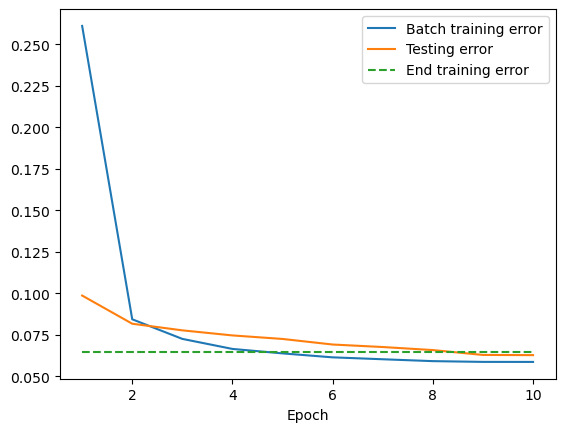

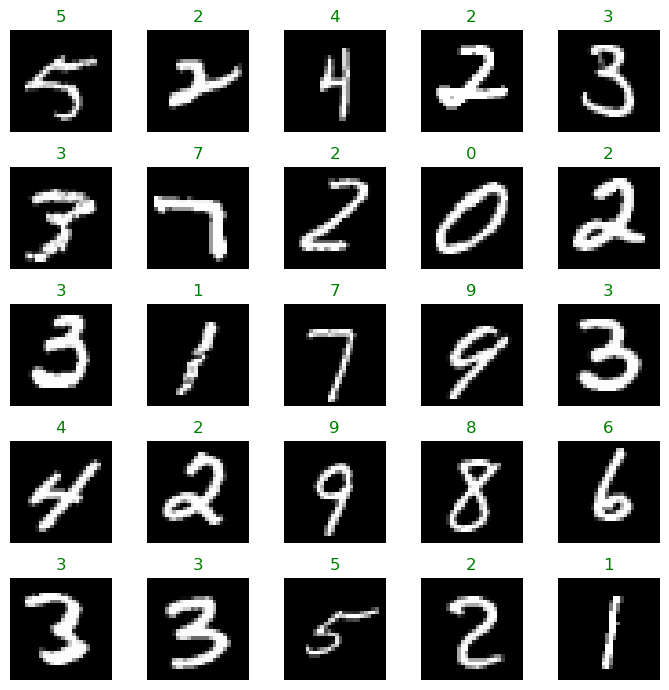

In [32]:
ex.plot_err()
ex.plot_pred(5)

In [33]:
ex.model.stack.FNN_lin_0

Linear(in_features=245, out_features=50, bias=True)

### Visualising hidden layers of the trained CNN

In [34]:
# Defining "forward hook" (see https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5)

activation = {} # Dictionary where outputs of different layers are stored
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Registering forward hooks to be placed into the dictionary `activation`
ind = np.random.randint(0,len(test_data) - 1)
ex.model.stack.Conv_1.register_forward_hook(get_activation('Conv_1'))
ex.model.stack.Act_1.register_forward_hook(get_activation('Act_1'))
ex.model.stack.Pool_1.register_forward_hook(get_activation('Pool_1'))
ex.model.stack.Conv_2.register_forward_hook(get_activation('Conv_2'))
ex.model.stack.Act_2.register_forward_hook(get_activation('Act_2'))
ex.model.stack.Pool_2.register_forward_hook(get_activation('Pool_2'))
ex.model.stack.FNN_lin_0.register_forward_hook(get_activation('FNN_lin_0'))
ex.model.stack.FNN_act_0.register_forward_hook(get_activation('FNN_act_0'))

x = test_data[ind][0].reshape(1,1,28,28)
output = ex.model(x)


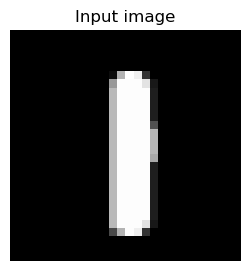

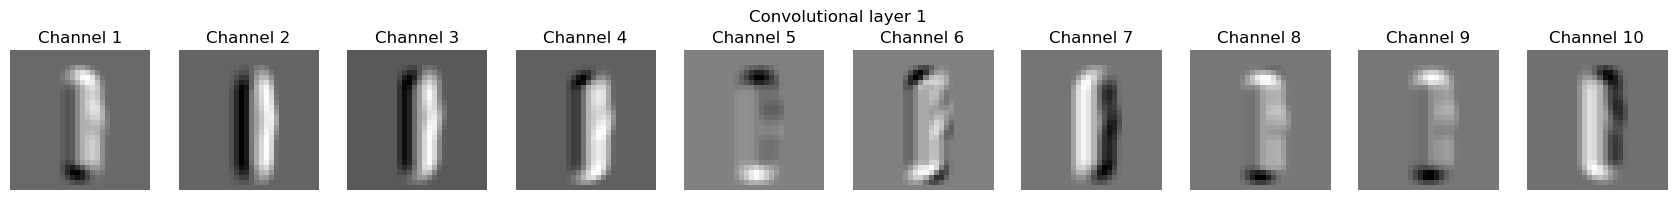

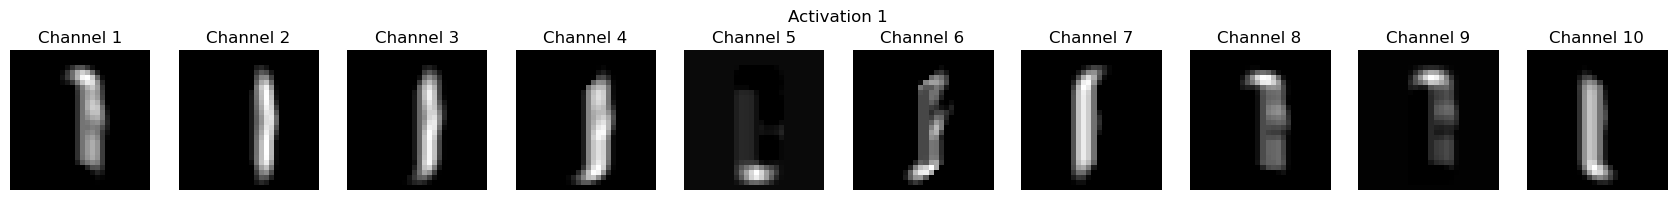

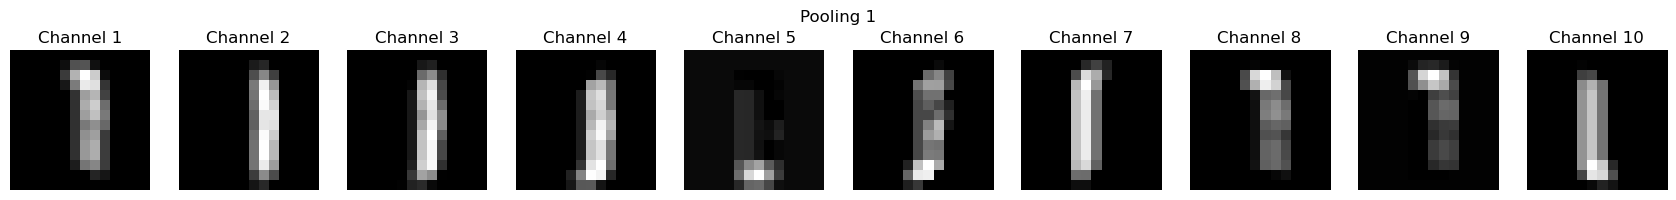

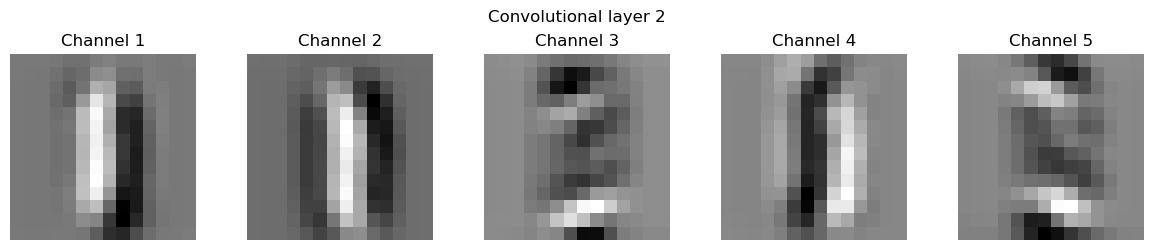

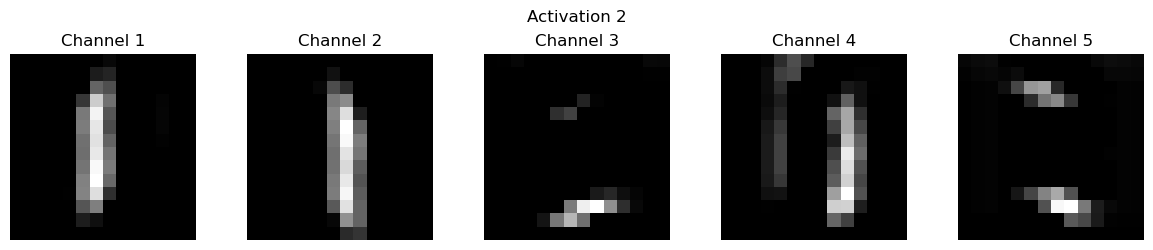

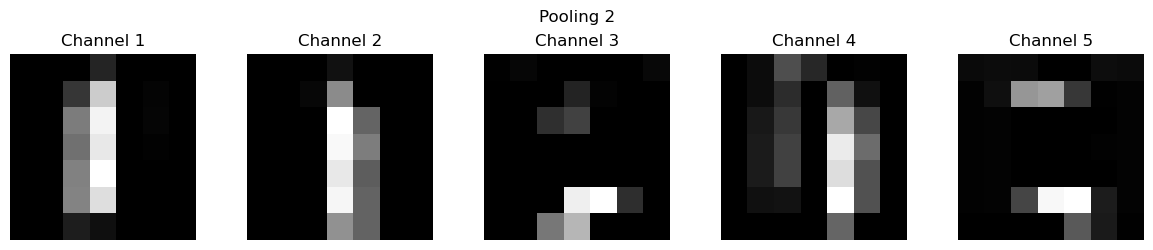

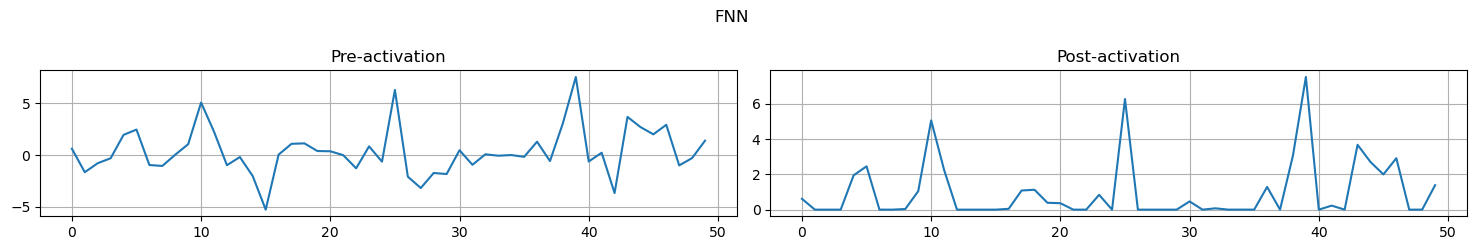

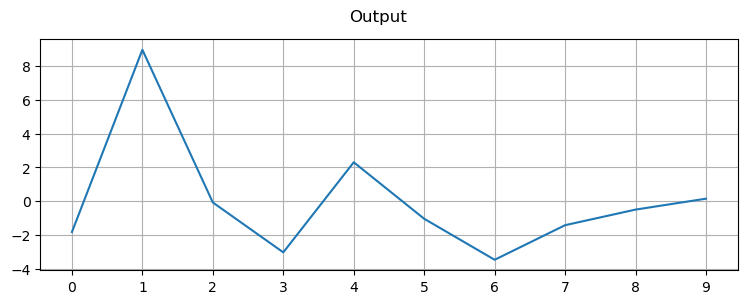

In [35]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
ax.imshow(x[0,0],cmap = 'gray')
ax.axis('off')
ax.set_title('Input image')
fig, ax = plt.subplots(1,10, figsize = (17,2))
fig.suptitle('Convolutional layer 1')
for i in range(10):
    ax[i].imshow(activation['Conv_1'][0][i],cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(f'Channel {i+1}')
fig.tight_layout()
fig, ax = plt.subplots(1,10, figsize = (17,2))
fig.suptitle('Activation 1')
for i in range(10):
    ax[i].imshow(activation['Act_1'][0][i],cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(f'Channel {i+1}')
fig.tight_layout()
fig, ax = plt.subplots(1,10, figsize = (17,2))
fig.suptitle('Pooling 1')
for i in range(10):
    ax[i].imshow(activation['Pool_1'][0][i],cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(f'Channel {i+1}')
fig.tight_layout()
fig, ax = plt.subplots(1,5, figsize = (12,2.5))
fig.suptitle('Convolutional layer 2')
for i in range(5):
    ax[i].imshow(activation['Conv_2'][0][i],cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(f'Channel {i+1}')
fig.tight_layout()
fig, ax = plt.subplots(1,5, figsize = (12,2.5))
fig.suptitle('Activation 2')
for i in range(5):
    ax[i].imshow(activation['Act_2'][0][i],cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(f'Channel {i+1}')
fig.tight_layout()
fig, ax = plt.subplots(1,5, figsize = (12,2.5))
fig.suptitle('Pooling 2')
for i in range(5):
    ax[i].imshow(activation['Pool_2'][0][i],cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(f'Channel {i+1}')
fig.tight_layout()
fig, ax = plt.subplots(1,2, figsize = (15,2.5))
ax[0].plot(activation['FNN_lin_0'][0])
ax[0].set_title('Pre-activation')
ax[0].grid()
ax[1].plot(activation['FNN_act_0'][0])
ax[1].grid()
ax[1].set_title('Post-activation')
fig.suptitle('FNN')
fig.tight_layout()
fig, ax = plt.subplots(1,1, figsize = (9,3))
ax.plot(output.detach()[0])
fig.suptitle('Output')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.grid()
plt.show()